<a href="https://colab.research.google.com/gist/ernestocl/0983861103570007179cffb96b83fafd/cnn-cifar10-tf11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [ ]:
from keras.backend_config import tf
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import *

from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model

## Parameters
num_classes = 10
num_epochs = 200
num_predictions = 10

## Hyper-parameters
batch_size = 32



Incorporamos la carpeta de Google Drive para poder "guardar" nuestros modelos

1. Abrir barra lateral de Carpeta
2.  Hacer click en carpeta con logo de Google Drive


In [ ]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
ANCHO_IMAGEN = 32
ALTURA_IMAGEN = 32
IMAGE_SIZE = (ANCHO_IMAGEN, ALTURA_IMAGEN)
CANALES_IMAGENES = 3


ruta_archivos = '/content/drive/MyDrive/MASTER EN DATA SCIENCE/Módulo 6 - Deep Learning/Módulo 6.1 - Deep Learning/6.3 Data Augmentation y Transfer Learning/Técnicas Avanzadas (perros y gatos)/'

In [ ]:
cifar10 = ks.datasets.cifar10

(x_train_img, y_train_img), (x_test_img, y_test_img) = cifar10.load_data()

x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.



In [ ]:
print("Etiquetas de train:", y_train_img)


# Convertir los datos en arrays de una dimension (vectores) es una buena mejora en el dataset
y_train_img = y_train_img.ravel()
y_test_img = y_test_img.ravel()


print("Etiquetas de train (en vector):", y_train_img)


Etiquetas de train: [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
Etiquetas de train (en vector): [6 9 9 ... 9 1 1]


Obtenemos un array con todas las labels de CIFAR10

In [ ]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


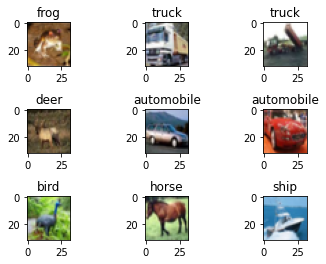

In [ ]:
# Pintemos una muestra de las las imagenes del dataset MNIST

print('Train: X=%s, y=%s' % (x_train_img.shape, y_train_img.shape))
print('Test: X=%s, y=%s' % (x_test_img.shape, y_test_img.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train_img[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_img[i]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [ ]:
y_train_img

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

In [ ]:
#converting the output labels to one hot encoding
#y_train_img = to_categorical(y_train_img, len(cifar10_labels))
#y_test_img = to_categorical(y_test_img, len(cifar10_labels))

x_val_scaled = x_train_scaled[-10000:]
y_val_img = y_train_img[-10000:]

x_train_scaled = x_train_scaled[:-10000]
y_train_img = y_train_img[:-10000]

In [ ]:
y_train_img

array([6, 9, 9, ..., 6, 2, 8], dtype=uint8)

In [ ]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train_img.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test_img.shape))
print('Validation: X=%s, y=%s' % (x_val_scaled.shape, y_val_img.shape))

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


In [ ]:
# creating data aguementaion object with required arguments
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.2,1.0],
    zoom_range=[0.5,1.0],
    featurewise_center=True,
    featurewise_std_normalization=True)

In [ ]:
# montamos la red neuronal
vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(ANCHO_IMAGEN, ALTURA_IMAGEN, CANALES_IMAGENES))

vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
output = vgg16_model.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
vgg16_new_model = Model(vgg16_model.input, new_output_layer)

vgg16_new_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
# Veamos como va lo de "congelar" capas de entrenamiento
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg16_new_model.layers]
pd.DataFrame(layers, columns=['Layer Type','Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f49194aa710>,input_5,True
1,<keras.layers.convolutional.Conv2D object at 0x7f49194aa510>,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0x7f49194a5350>,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0x7f49194401d0>,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0x7f4919491fd0>,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0x7f491944bc50>,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0x7f49194535d0>,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0x7f4919457190>,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0x7f491945a650>,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0x7f491945bf50>,block3_conv3,True


In [ ]:
trainable = False

for layer in vgg16_new_model.layers:
  if layer.name == "block4_conv1":
    trainable = True
  layer.trainable = trainable

pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg16_new_model.layers]
pd.DataFrame(layers, columns=['Layer Type','Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f49194aa710>,input_5,False
1,<keras.layers.convolutional.Conv2D object at 0x7f49194aa510>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f49194a5350>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f49194401d0>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f4919491fd0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f491944bc50>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f49194535d0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f4919457190>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f491945a650>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f491945bf50>,block3_conv3,False


In [ ]:
vgg16_new_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
# Definamos el output de salida de la transformacion VGG16
output_from_vgg16 = vgg16_new_model.output_shape[1]
print(output_from_vgg16) #TODO

print(vgg16_new_model.output_shape)

512
(None, 512)


In [ ]:
model_with_vgg16 = ks.Sequential()

model_with_vgg16.add(vgg16_new_model)

#model_with_vgg16.add(ks.layers.InputLayer(input_shape=(output_from_vgg16))) 
model_with_vgg16.add(ks.layers.Dense(512, activation='relu', input_shape=(output_from_vgg16,)))
model_with_vgg16.add(ks.layers.Dropout(0.3))
model_with_vgg16.add(ks.layers.Dense(512, activation='relu'))
model_with_vgg16.add(ks.layers.Dropout(0.3))
model_with_vgg16.add(ks.layers.Dense(10, activation='softmax'))

model_with_vgg16.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_4 (Functional)        (None, 512)               14714688  
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 10)                5130      
                                                                 
Total params: 15,245,130
Trainable params: 13,509,642


In [ ]:
tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    decay=1e-6,
    epsilon=1e-07,
    centered=False,
    name="RMSprop")

In [ ]:
 # optimizer
opt = tf.keras.optimizers.RMSprop(lr=1e-4, decay=1e-6)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model_with_vgg16.compile(loss='categorical_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'])

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [ ]:
print(np.array(y_train_img))
print(np.array(y_train_encoded))

y_train_encoded

[6 9 9 ... 6 2 8]
[6 9 9 ... 6 2 8]


array([6, 9, 9, ..., 6, 2, 8])

In [ ]:
# fitting training data to out datagen object
datagen.fit(x_train_scaled)

In [ ]:
history = model_with_vgg16.fit(datagen.flow(x_train_scaled, y_train_encoded, batch_size=batch_size),
                            steps_per_epoch=x_train_scaled.shape[0] // batch_size, epochs=num_epochs,
                            validation_data=(x_test_scaled, y_test_encoded))

NameError: ignored

In [ ]:
evaluation = history.evaluate_generator(datagen.flow(x_test_scaled, y_test_encoded, batch_size=batch_size), steps=x_test_scaled.shape[0] // batch_size)
                                        
print('Model accuracy = %.2f' % evaluation[1])

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()